In [1]:
import numpy as np
import matplotlib.pyplot as plt

import firedrake
import icepack
import icepack.plot

import os
os.environ["OMP_NUM_THREADS"] = "1"

ModuleNotFoundError: No module named 'firedrake'

In [31]:
nx, ny = 64, 16
Lx, Ly = 5000, 1000
mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

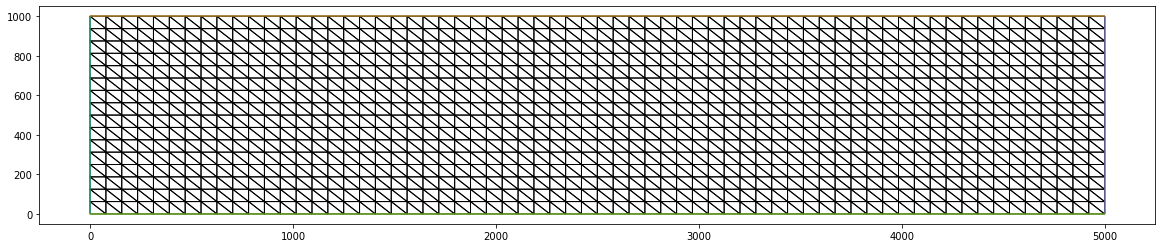

In [17]:
fig, ax = plt.subplots(figsize = (20, 4))
icepack.plot.triplot(mesh, axes = ax)
plt.show()

In [27]:
Q = firedrake.FunctionSpace(mesh, family = 'CG', degree = 2)
V = firedrake.VectorFunctionSpace(mesh, family = 'CG', degree = 2)
x, y = firedrake.SpatialCoordinate(mesh)

In [36]:
s_in, s_out = 600, 100
s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

b_in, b_out = 100, 50
b0 = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

h_in = s_in - b_in
h_out = s_out - b_out
h0 = firedrake.interpolate(s0 - b0, Q)

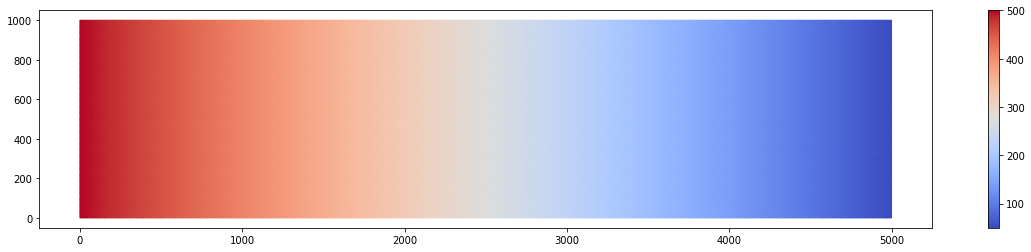

In [37]:
fig, ax = plt.subplots(figsize = (20, 4))
im = icepack.plot.tripcolor(h0, axes = ax, cmap = 'coolwarm')
plt.colorbar(im)
plt.show()

In [38]:
model = icepack.models.ShallowIce()
solver = icepack.solvers.FlowSolver(model)

In [39]:
T = firedrake.Constant(273.15 - 5)
A = icepack.rate_factor(T)

In [43]:
u0 = firedrake.Function(V)
h = h0.copy(deepcopy = True)
u_s = solver.diagnostic_solve(
    velocity = u0,
    thickness = h,
    surface = s0,
    fluidity = A
)

u_b = firedrake.interpolate(0.6 * u_s, V)

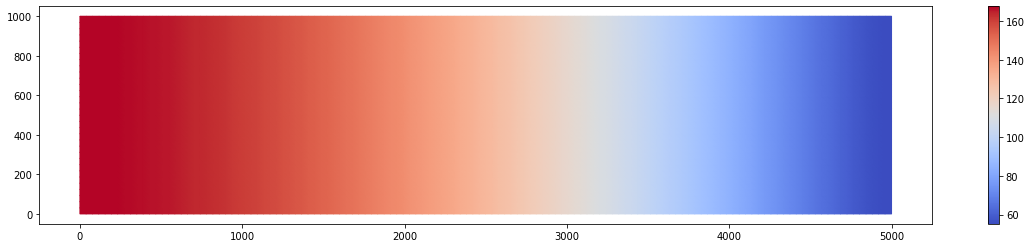

In [46]:
fig, ax = plt.subplots(figsize = (20, 4))
im = icepack.plot.tripcolor(u_b, axes = ax, cmap = 'coolwarm')
plt.colorbar(im)
plt.show()

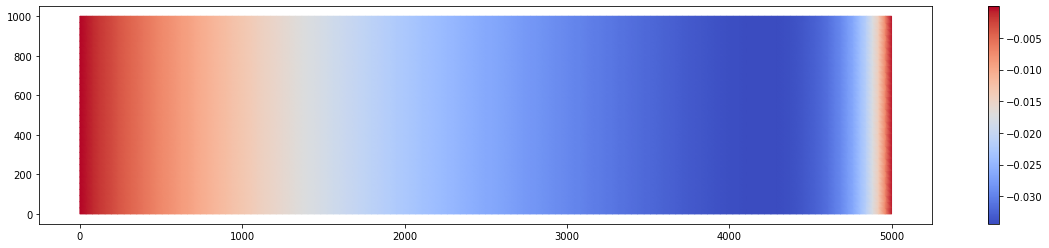

In [48]:
div = firedrake.interpolate(firedrake.div(u_b), Q)

fig, ax = plt.subplots(figsize = (20, 4))
im = icepack.plot.tripcolor(div, axes = ax, cmap = 'coolwarm')
plt.colorbar(im)
plt.show()

In [101]:
array_conductivity = 2e-15 * 3.14e7 # m^2 Pa^-1 s^-1
N_scaling = 0.05
effective_pressure = firedrake.interpolate(917 * 9.81 * h * N_scaling, Q)

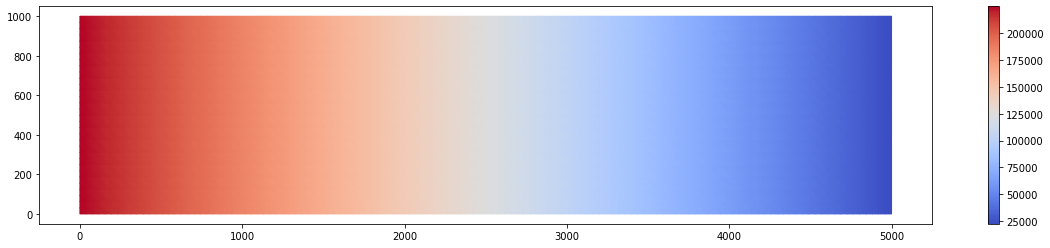

In [102]:
fig, ax = plt.subplots(figsize = (20, 4))
im = icepack.plot.tripcolor(effective_pressure, axes = ax, cmap = 'coolwarm')
plt.colorbar(im)
plt.show()

In [121]:
minimum_value = 1e-5
z = firedrake.interpolate(firedrake.Constant(minimum_value), Q)
nt = 100
time_elapsed = 0.0
CFL = 0.2

for i in range(nt):
    regelation_rate = firedrake.interpolate(array_conductivity * (effective_pressure / z), Q)
    
    dt_cfl = (CFL * (Lx / nx)) / regelation_rate.dat.data_ro[:].max()
    dt = min(dt_cfl, 1.0)
    
    new_z = firedrake.interpolate(z + regelation_rate * dt, Q)
    
    z = new_z.copy(deepcopy = True)
    time_elapsed += dt
    
    if i % 5 == 0:
        print('Time elapsed: ' + str(np.round(time_elapsed, 2)) + ' years.')
        
    if time_elapsed > 100:
        break
        
print('Time elapsed: ' + str(np.round(time_elapsed, 2)) + ' years.')

Time elapsed: 0.01 years.
Time elapsed: 5.01 years.
Time elapsed: 10.01 years.
Time elapsed: 15.01 years.
Time elapsed: 20.01 years.
Time elapsed: 25.01 years.
Time elapsed: 30.01 years.
Time elapsed: 35.01 years.
Time elapsed: 40.01 years.
Time elapsed: 45.01 years.
Time elapsed: 50.01 years.
Time elapsed: 55.01 years.
Time elapsed: 60.01 years.
Time elapsed: 65.01 years.
Time elapsed: 70.01 years.
Time elapsed: 75.01 years.
Time elapsed: 80.01 years.
Time elapsed: 85.01 years.
Time elapsed: 90.01 years.
Time elapsed: 95.01 years.
Time elapsed: 99.01 years.


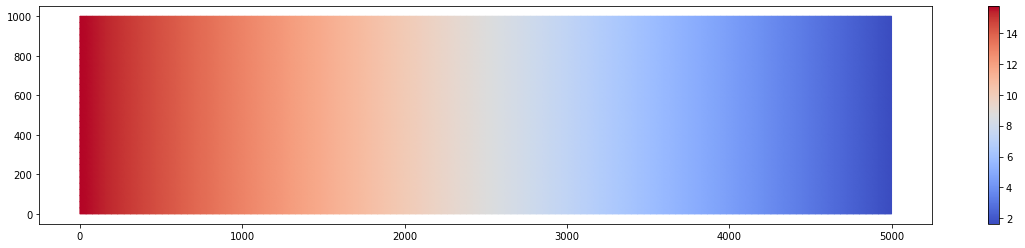

In [122]:
fig, ax = plt.subplots(figsize = (20, 4))
im = icepack.plot.tripcolor(z, axes = ax, cmap = 'coolwarm')
plt.colorbar(im)
plt.show()